Idea: Show the tradeoffs between explicitly depending on (+ profiling) and removing dependence on a given systematic uncertainty using the ideas from [1601.07913](https://arxiv.org/pdf/1601.07913.pdf) and [1611.01046](https://arxiv.org/pdf/1611.01046.pdf) (code is [here](https://github.com/glouppe/paper-learning-to-pivot/blob/master/code/Toy.ipynb)).

In [1]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

/public/apps/anaconda3/5.0.1/envs/fair_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First, let's generate some toy data.

In [2]:
N = 10000
N2 = int(N/2)
sigma = 0.25
signals = {} # dict of mean : list of random draws from N(+-mean, sigma)
backgrounds = {} # dict of one element, 0 : list of random draws from N(0, sigma)
signal_tot = [] # numpy.ndarray of entries [draw, mean]
background_tot = [] # numpy.ndarray of entries [draw from N(0, sigma), mean of signal]
means = [0, 0.5, 1, 1.5, 2]
for mean in means:
    signal = list(zip(np.random.normal(-mean, sigma, N2), mean * np.ones(N2)))
    signal += list(zip(np.random.normal(mean, sigma, N2), mean * np.ones(N2)))

    background = list(zip(np.random.normal(0, sigma, N), mean * np.ones(N)))
    #signals[mean]=np.random.normal(-mean,sigma,N2)
    signals[mean] = np.concatenate((
        np.random.normal(-mean, sigma, N2),
        np.random.normal(mean, sigma, N2)
    ))

    backgrounds[mean] = np.random.normal(0, sigma, N)
    
    if (len(signal_tot) > 0):
        signal_tot = np.concatenate((signal_tot,signal))
        background_tot = np.concatenate((background_tot,background))
    else:
        signal_tot = signal
        background_tot = background

In [122]:
N = 100000
sigma = 0.25
signals = {}
backgrounds = {}

# signal events are composed of N*fraction * signal + N*(1-fraction) * background
# background events, instead, only comprise the background component N*background

signal_tot = [] # numpy.ndarray of entries [event, mean]
background_tot = [] # numpy.ndarray of entries [event, mean]
signal_fractions = [1., 0.8, 0.6, 0.4, 0.2, 0.0]

for fraction in signal_fractions:
    signal = list(zip(
        np.random.normal(0, sigma, int(N * fraction)),
        fraction * np.ones(int(N * fraction))
    ))
    signal += list(zip(
        np.random.uniform(-2, 2, int(N * (1 - fraction))),
        fraction * np.ones(int(N * (1 - fraction)))
    ))
    background = list(zip(
        np.random.uniform(-2, 2, N),
        fraction * np.ones(N)
    ))
    signals[fraction] = np.concatenate((
        np.random.normal(0, sigma, int(N * fraction)),
        np.random.uniform(-2, 2, int(N * (1 - fraction)))
    ))
    backgrounds[fraction] = np.random.uniform(-2, 2, N)
    if (len(signal_tot) > 0):
        signal_tot = np.concatenate((signal_tot, signal))
        background_tot = np.concatenate((background_tot, background))
    else:
        signal_tot = signal
        background_tot = background

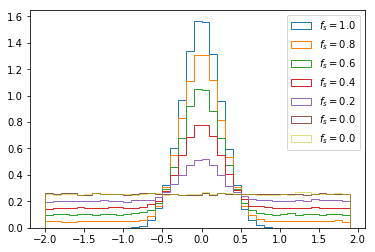

In [131]:
# colors=['b','g','r','c','m']
for i in range(len(signals)):
    _ = plt.hist(
        signals[signal_fractions[i]],
        bins=np.arange(-2,2,0.1),
#         color=colors[i],
#         alpha=0.5,
        rwidth=0.85,
        density=True,
        label=r'$f_s=$' + str(signal_fractions[i]),
        histtype='step'
    )

# any of the entries in backgrounds would have worked
_ = plt.hist(backgrounds[0.2], bins=np.arange(-2,2,0.1), color='y', alpha=0.5, rwidth=0.85, density=True, 
             label=r'$f_s=0.0$',histtype='step')
plt.legend()

In [132]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [133]:
signal_labels = np.ones(len(signal_tot))
background_labels = np.zeros(len(background_tot))
X = np.concatenate((signal_tot, background_tot))
Y = np.concatenate((signal_labels, background_labels))

In [134]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
# Fit the model
model.fit(X, Y, epochs=2, batch_size=1000)

Epoch 1/2
1199999/1199999 [==============================] - 4s 3us/step - loss: 0.6001 - acc: 0.6694
Epoch 2/2
1199999/1199999 [==============================] - 4s 3us/step - loss: 0.5811 - acc: 0.6755


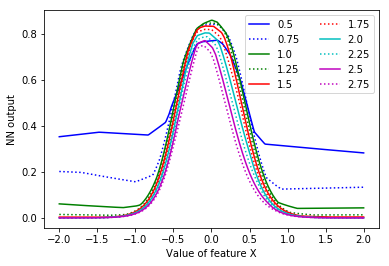

In [136]:
verts = []

xvals = np.linspace(-2, 2, 400)  # draws, or events (X)

fig, ax = plt.subplots()

colors=['b','b','g','g','r','r','c','c','m','m']
nus = [0.5, 0.75, 1., 1.25, 1.5, 1.75, 2., 2.25, 2.5, 2.75]  # list of \nu's

# build test set of (X, \nu): 
# all xvals are the same for all \nu datasets, \nu's are contant but vary dataset by dataset
for i in range(len(nus)):
    X_test = list(zip(xvals, nus[i] * np.ones(len(xvals))))
    nn_output = model.predict(np.array(X_test))
    if (i%2==1):
        ax.plot(xvals, nn_output, color=colors[i], linestyle=':', label=str(nus[i]))
    else:
        ax.plot(xvals, nn_output, color=colors[i], label=str(nus[i]))
    
    verts.append(list(zip(xvals, nn_output)))

ax.set_xlabel('Value of feature X')
ax.set_ylabel('NN output')
_ = ax.legend(ncol=2)

# Explanation:
# for lower values of \nu, the value of x where the signal clearly dominates over the background gets closer to the
# peak, whereas for larger values of \nu, many more values of X will look more signal-like than bkg-like

In [137]:
verts = np.array(verts)
verts[:, 0, 1] = 0
verts[:, -1, 1] = 0

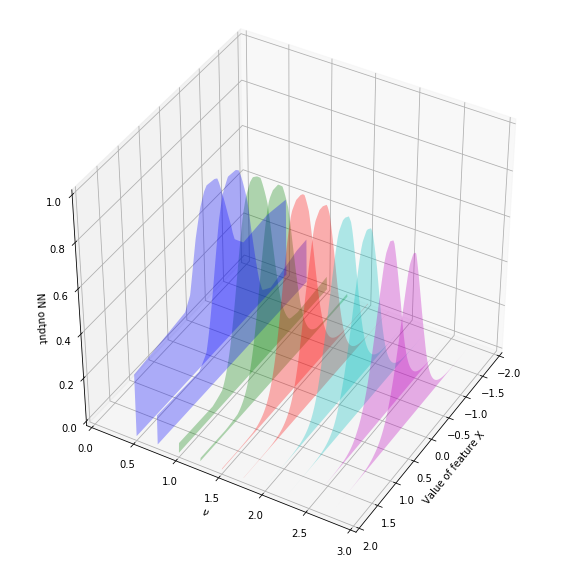

In [138]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.view_init(40, 30) # rotate this as you wish!

poly = PolyCollection(verts, facecolors=colors)
poly.set_alpha(0.3)

zs = range(np.array(verts).shape[0])
ax.add_collection3d(poly, zs=nus, zdir='y')

ax.set_xlabel('Value of feature X')
ax.set_xlim3d(-2, 2)
ax.set_ylabel(r'$\nu$')
ax.set_ylim3d(0, 3)
ax.set_zlabel('NN output')
ax.set_zlim3d(0, 1)

plt.show()

Now, let's try with an adversary.

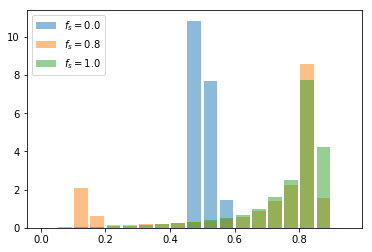

In [140]:
# Recall: signal_tot is a numpy array of [X, \nu] entries for signal events

# colors = ['0.2','0.4','0.6','0.8','1.0']
nus = [0., 0.8, 1.0]
bins = np.arange(0, 1, 0.05)

for nu in nus:
    # extract values of feature X for all signal events at \nu = nu
    # vals = signal_tot[signal_tot[:, 1] == nu, 0] 
    
    # extract [X, \nu] samples for all signal events at \nu = nu
    vals2 = signal_tot[signal_tot[:, 1] == nu] 
    # get model predictions for each [X, \nu] pair
    predictions = model.predict(vals2)
    
    # plot histogram of predictions (one of each \nu value)
    plt.hist(predictions,
             bins=bins,
             # color=colors[j],
             alpha=0.5,
             rwidth=0.85,
             density=True,
             label=r'$f_s=$' + str(nu),
    )

_ = plt.legend()

# The distributions are different, meaning that the more signal like samples will be easier to distinguish from
# a background only sample, while as f_s (or nu) go to 0, the network should output approximately 0.5

Note: we will have a prior on the nuisance parameter and probably we will want to weight the training samples so that their contribution the loss is proportional to this prior weight (otherwise, the adversary will too harshly penalize extreme examples of the nuisance parameter!)

In [842]:
LAMBDA = 1.0  # importance auxiliary task / importance main classifier

In [843]:
# feature building model 1 --> 64

In [844]:
FEATURE_LENGTH = 64

inputs = Input((1,), name='input')
feats_h = Dense(64, activation='relu', name='shared1')(inputs)
feats = Dense(FEATURE_LENGTH, activation='relu', name='shared2')(feats_h)
featbuilder = Model(inputs, feats)

In [845]:
featbuilder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
shared1 (Dense)              (None, 64)                128       
_________________________________________________________________
shared2 (Dense)              (None, 64)                4160      
Total params: 4,288
Trainable params: 4,288
Non-trainable params: 0
_________________________________________________________________


In [846]:
featbuilder.compile('Adam', loss='mse') # doesn't matter what loss
featbuilder.name = 'featurebuilder'

In [847]:
# aux branch 64 --> 1

In [848]:
temp_input = Input((FEATURE_LENGTH,))
h = Dense(64, activation='relu', name='aux1')(temp_input)
aux = Dense(1, activation='sigmoid', name='aux2')(h) # nu is between 0 and 1 for now (also for stability)
auxonly = Model(temp_input, aux)

In [849]:
auxonly.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 64)                0         
_________________________________________________________________
aux1 (Dense)                 (None, 64)                4160      
_________________________________________________________________
aux2 (Dense)                 (None, 1)                 65        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [850]:
auxonly.name = 'auxonly'

In [851]:
# auxiliary model 1 --> 1

In [852]:
features = featbuilder(inputs)
aux_out = auxonly(features)

In [853]:
auxmodel = Model(inputs, aux_out)

In [854]:
auxmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
featurebuilder (Model)       (None, 64)                4288      
_________________________________________________________________
auxonly (Model)              (None, 1)                 4225      
Total params: 8,513
Trainable params: 8,513
Non-trainable params: 0
_________________________________________________________________


In [855]:
auxmodel.get_layer(name='featurebuilder').trainable = False

In [856]:
auxmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
featurebuilder (Model)       (None, 64)                4288      
_________________________________________________________________
auxonly (Model)              (None, 1)                 4225      
Total params: 8,513
Trainable params: 4,225
Non-trainable params: 4,288
_________________________________________________________________


In [857]:
auxmodel.compile('Adam', loss='mse')
auxmodel.name = 'auxmodel'

In [858]:
# classifier only model 64 --> 1

In [859]:
temp_input2 = Input((FEATURE_LENGTH,))
clf_h = Dense(64, activation='relu', name='clf1')(temp_input2)
clf = Dense(1, activation='sigmoid', name='clf2')(clf_h)
clfonly = Model(temp_input2, clf)

In [860]:
clfonly.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 64)                0         
_________________________________________________________________
clf1 (Dense)                 (None, 64)                4160      
_________________________________________________________________
clf2 (Dense)                 (None, 1)                 65        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [861]:
clfonly.name = 'clfonly'

In [862]:
# whole model 1 --> 1, 1

In [863]:
features = featbuilder(inputs)
aux_out = auxonly(features)
clf_out = clfonly(features)

In [864]:
wholemodel = Model(inputs, [clf_out, aux_out])

In [865]:
wholemodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
featurebuilder (Model)          (None, 64)           4288        input[0][0]                      
__________________________________________________________________________________________________
clfonly (Model)                 (None, 1)            4225        featurebuilder[2][0]             
__________________________________________________________________________________________________
auxonly (Model)                 (None, 1)            4225        featurebuilder[2][0]             
Total params: 12,738
Trainable params: 8,450
Non-trainable params: 4,288
____________________________________

In [866]:
wholemodel.get_layer(name='featurebuilder').trainable = True

In [867]:
wholemodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
featurebuilder (Model)          (None, 64)           4288        input[0][0]                      
__________________________________________________________________________________________________
clfonly (Model)                 (None, 1)            4225        featurebuilder[2][0]             
__________________________________________________________________________________________________
auxonly (Model)                 (None, 1)            4225        featurebuilder[2][0]             
Total params: 12,738
Trainable params: 12,738
Non-trainable params: 0
_______________________________________

In [868]:
wholemodel.get_layer(name='auxonly').trainable = False

In [869]:
wholemodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
featurebuilder (Model)          (None, 64)           4288        input[0][0]                      
__________________________________________________________________________________________________
clfonly (Model)                 (None, 1)            4225        featurebuilder[2][0]             
__________________________________________________________________________________________________
auxonly (Model)                 (None, 1)            4225        featurebuilder[2][0]             
Total params: 12,738
Trainable params: 8,513
Non-trainable params: 4,225
____________________________________

In [870]:
wholemodel.compile('Adam', loss=['binary_crossentropy', 'mse'], loss_weights=[1, -1 * LAMBDA])

In [871]:
# we have 2 models we want to train: wholemodel (where the auxiliary branch is frozen) and auxmodel (where the
# featured building shared weights are frozen). I hope the weight sharing works because I have no idea what I'm doing.

# Train and Test

In [872]:
# get predictions from untrained model to check output is okay
yhat = wholemodel.predict(X[:, 0], batch_size=1000, verbose=True)

1199999/1199999 [==============================] - 6s 5us/step


In [873]:
yhat = np.array(yhat)

In [874]:
yhat[:, 0]  # the two outputs for event 0: signal vs bkg, guessing nu

array([[0.5007725 ],
       [0.49842677]], dtype=float32)

In [875]:
# Train
from collections import defaultdict
nb_epochs = 10

In [876]:
train_history = defaultdict(list)
test_history = defaultdict(list)

for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(epoch + 1, nb_epochs))
    
    print('Training auxiliary branch only on aux task')
    auxmodel.fit(X[:, 0], X[:, 1], batch_size=1000)
    print('Training shared + classifier portions on minimizing clf loss and maximizing aux loss')
    wholemodel.fit(X[:, 0], [Y, X[:, 1]], batch_size=1000)


Epoch 1 of 10
Training auxiliary branch only on aux task
Epoch 1/1
1199999/1199999 [==============================] - 8s 7us/step - loss: 0.1097
Training shared + classifier portions on minimizing clf loss and maximizing aux loss
Epoch 1/1
1199999/1199999 [==============================] - 12s 10us/step - loss: 0.2777 - clfonly_loss: 0.6246 - auxonly_loss: 0.3468
Epoch 2 of 10
Training auxiliary branch only on aux task
Epoch 1/1
1199999/1199999 [==============================] - 7s 6us/step - loss: 0.1119
Training shared + classifier portions on minimizing clf loss and maximizing aux loss
Epoch 1/1
1199999/1199999 [==============================] - 11s 9us/step - loss: 0.2685 - clfonly_loss: 0.6224 - auxonly_loss: 0.3539
Epoch 3 of 10
Training auxiliary branch only on aux task
Epoch 1/1
1199999/1199999 [==============================] - 7s 6us/step - loss: 0.1175
Training shared + classifier portions on minimizing clf loss and maximizing aux loss
Epoch 1/1
1199999/1199999 [============

In [877]:
# Test (on training set for now)

In [878]:
yhat, nuhat = wholemodel.predict(X[:, 0], batch_size=1000, verbose=True)

1199999/1199999 [==============================] - 5s 4us/step


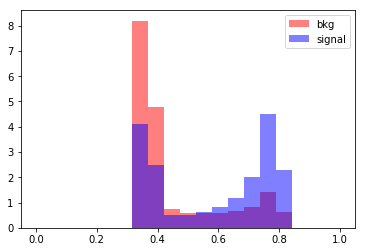

In [879]:
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[Y==0], bins=bins, color='red', histtype='stepfilled', alpha=0.5, density=True, label='bkg')
_ = plt.hist(yhat[Y==1], bins=bins, color='blue', histtype='stepfilled', alpha=0.5, density=True, label='signal')
_ = plt.legend()

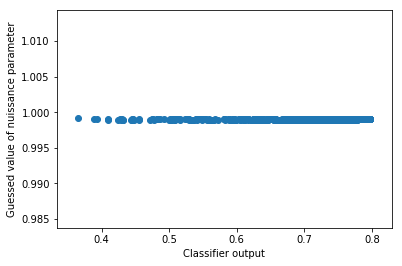

In [880]:
plt.scatter(yhat[:1000], nuhat[:1000])
plt.xlabel('Classifier output')
_ = plt.ylabel('Guessed value of nuissance parameter')

# Old stuff

In [ ]:
predictions = np.ones(len(X))
for i in range(1):
    auto_input = X
    train_autoencoder_model.fit(X, [Y,predictions], epochs=1, batch_size=10) 

In [ ]:
predictions = train_autoencoder_model.predict(X)

In [ ]:
fpr, tpr, _ = roc_curve(Y, predictions)

In [ ]:
plt.plot(fpr, tpr, color='black')

In [ ]:
predictions = model.predict(X)

In [ ]:
Q=[x[1] for x in X]

In [ ]:
model2 = Sequential()
model2.add(Dense(12, input_dim=1, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(predictions, Q, epochs=2, batch_size=10)

In [ ]:
predictions2 = model2.predict(predictions)

In [ ]:
plt.scatter(Q, predictions, color='black')

In [ ]:
signal_tot[len(signal_tot)-100:len(signal_tot)-1]

For fun, let's try the example from the pivot paper.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
np.random.seed = 333

In [ ]:
from carl.distributions import Mixture, MultivariateNormal, Uniform, Normal

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.array([[1., -0.5], [-0.5, 1.]]))
p1 = MultivariateNormal(mu=np.array([1., 1.]), sigma=np.eye(2))
pz = Normal(mu=0.0, sigma=1.0)

In [ ]:
n_samples = 125000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

In [ ]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [ ]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=50000)

In [ ]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

n_components = 5
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="linear")(Rx)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Merge(mode="concat")([mu, sigma, pi])

R = Model(input=[inputs], output=[Rx])